In [74]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
#import plotly.express as px
from statsmodels.graphics import tsaplots
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from yahoo_fin.stock_info import get_data
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split
from datetime import timedelta
from scipy.stats import norm

# Getting the data

We are using the python lybrary "yahoo_fin" to get the data from the yahoo api

In [75]:
df = get_data("^GSPC")
df.to_csv("df.csv")
df = df.drop('ticker', axis=1)
df.head()

open       high        low      close   adjclose    volume
1970-03-25   0.0  91.070000  88.110001  89.769997  89.769997  17500000
1970-03-26   0.0  90.650002  89.180000  89.919998  89.919998  11350000
1970-03-30   0.0  90.410004  88.910004  89.629997  89.629997   9600000
1970-03-31   0.0  90.169998  88.849998  89.629997  89.629997   8370000
1970-04-01   0.0  90.620003  89.300003  90.070000  90.070000   9810000

In [76]:
df.describe()


open          high           low         close      adjclose  \
count  13571.000000  13571.000000  13571.000000  13571.000000  13571.000000   
mean    1034.335500   1063.489503   1050.449024   1057.392051   1057.392051   
std     1133.273650   1119.228326   1106.540983   1113.281995   1113.281995   
min        0.000000     63.230000     60.959999     62.279999     62.279999   
25%      157.904999    158.580002    157.115005    157.985001    157.985001   
50%      754.849976    758.340027    747.710022    754.849976    754.849976   
75%     1397.020020   1404.414978   1386.599976   1397.700012   1397.700012   
max     4804.509766   4818.620117   4780.979980   4796.560059   4796.560059   

             volume  
count  1.357100e+04  
mean   1.578298e+09  
std    1.869576e+09  
min    6.650000e+06  
25%    8.101000e+07  
50%    4.717400e+08  
75%    3.278300e+09  
max    1.145623e+10

# Analyzing the time series
Now that we have the data we can start analyzing it
## Time series Plots

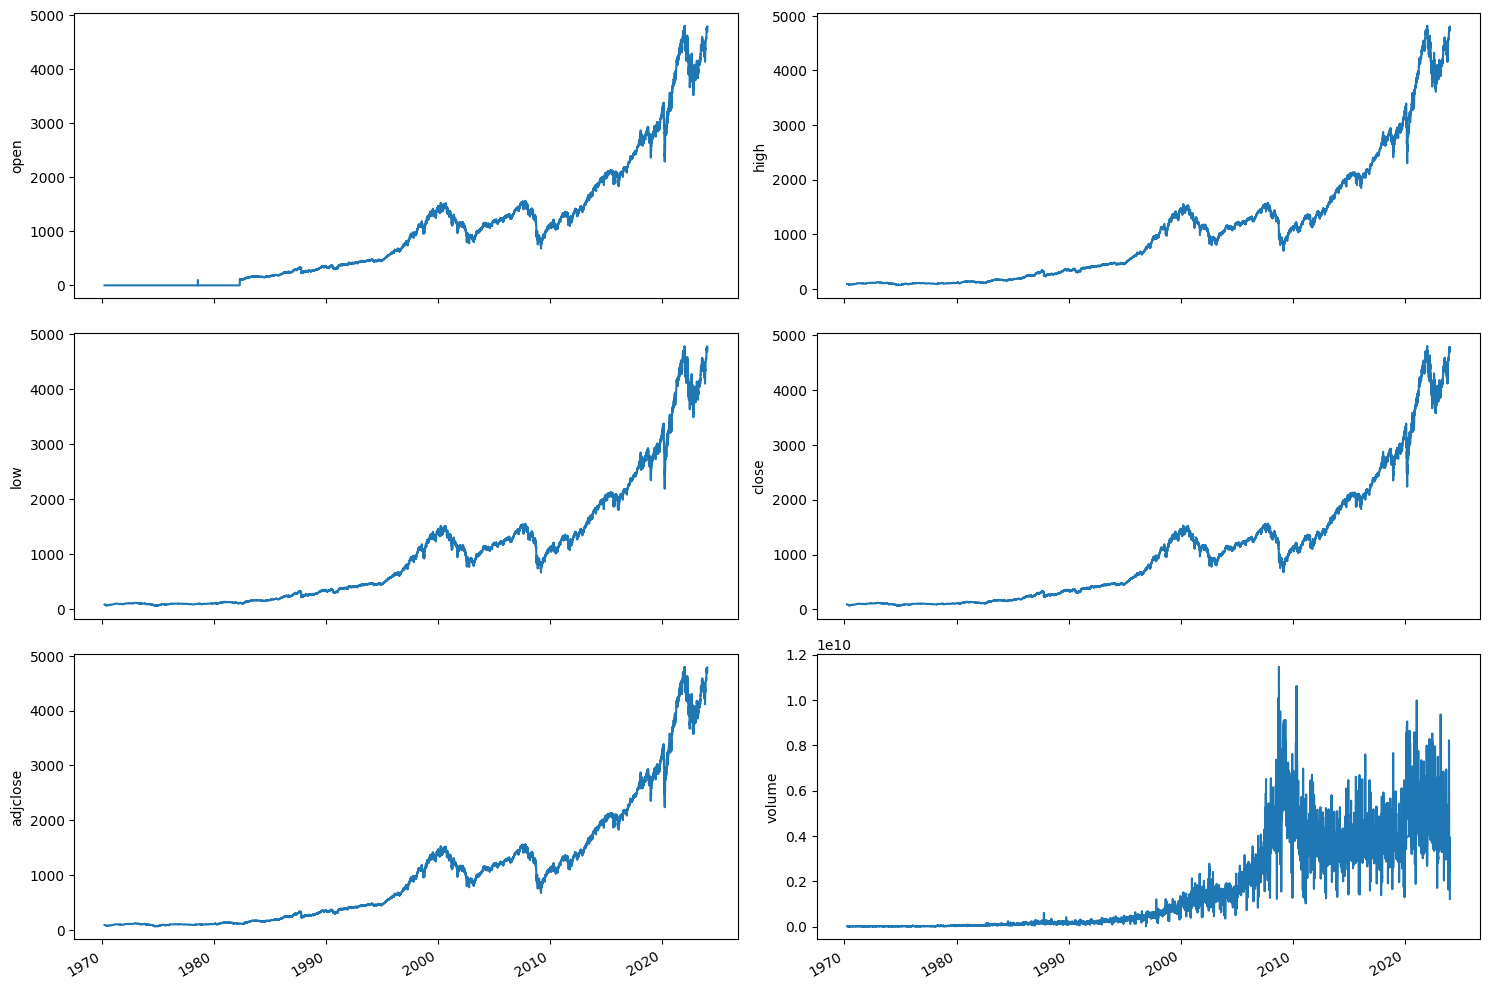

In [77]:
labels = df.columns.values

plt.figure(figsize=(15,10))
p = 1
for label in labels:
    plt.subplot(3,2,p)
    p +=1
    plt.plot(df.index,df[label])
    plt.ylabel(label)
    date_format = mdates.DateFormatter("%Y")
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

## Chossing variable to study

Because our data has multiple variables we need to decide on one to study we decided to use the variable "adjclose".

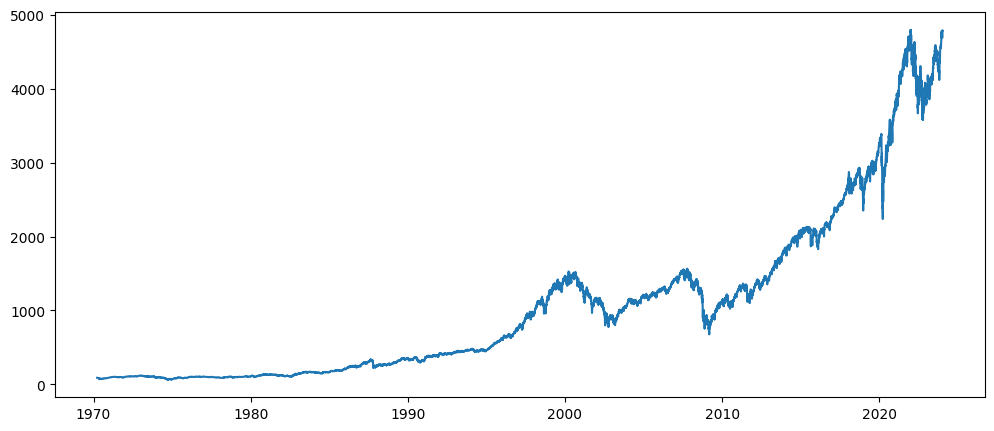

In [78]:
var = 'adjclose'
plt.figure(figsize=(12,5))
plt.plot(df.index,df[var])
plt.show()

## Decomposing the time series

In [79]:
def seasonal_decomposition(df, column_name):

    result_mul = seasonal_decompose(df[column_name], model='multiplicative', period=12, extrapolate_trend='freq')
    result_add = seasonal_decompose(df[column_name], model='additive', period=12, extrapolate_trend='freq')
    
    return result_mul, result_add

def plot_decompostion(df, column_name, decomposition):
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(df[column_name], label='Original TS')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition.seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='best')
    plt.show()

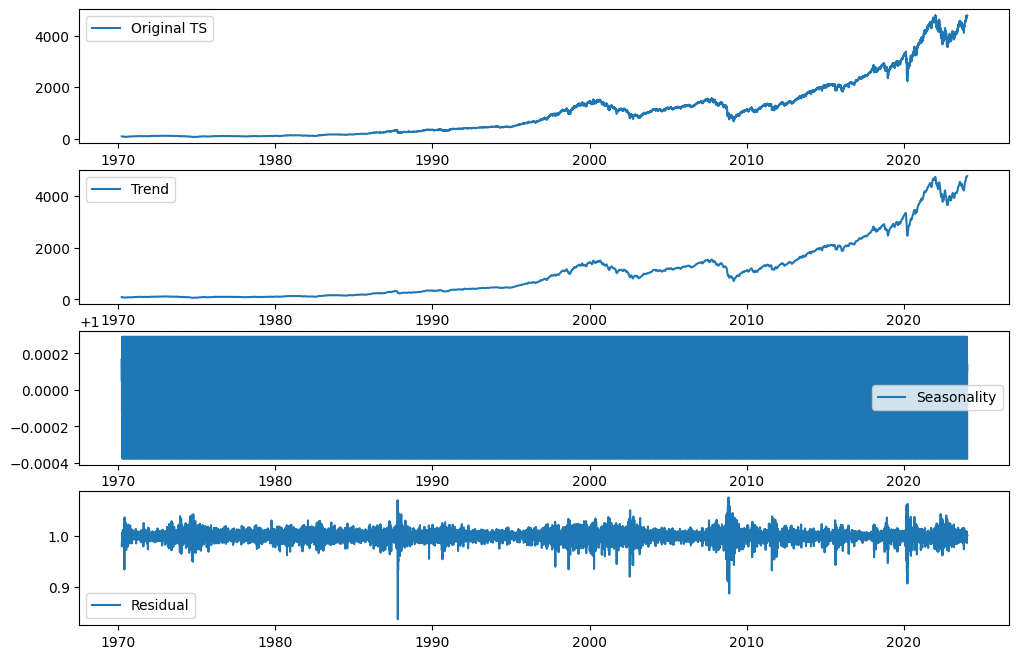

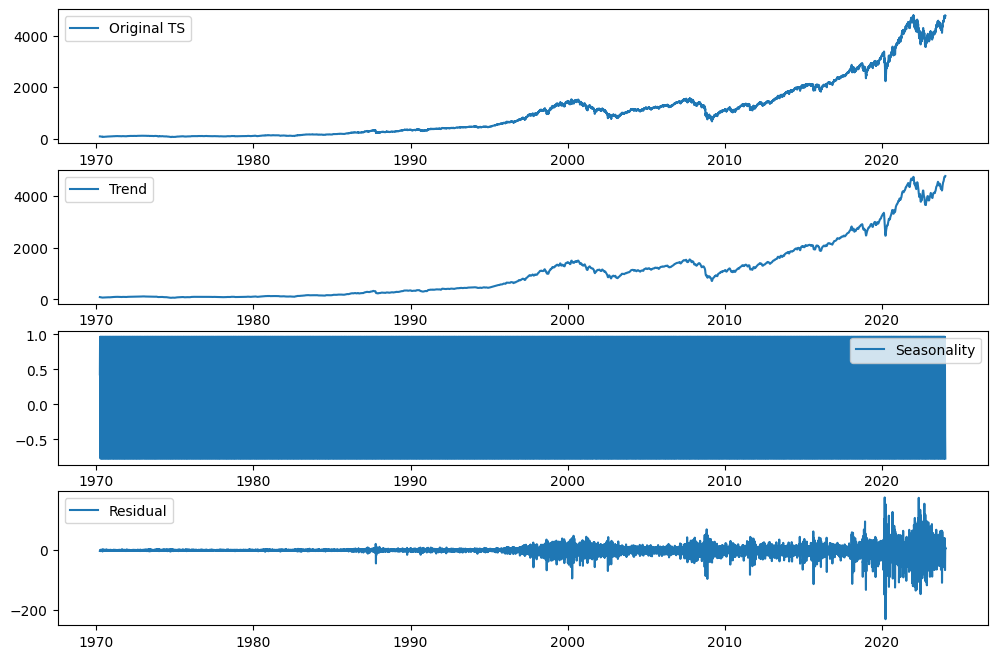

In [80]:
result_mult, result_add = seasonal_decomposition(df,var)

plot_decompostion(df,var,result_mult)
plot_decompostion(df,var,result_add)


### Auto-correlation function of the residuals of the decomposition

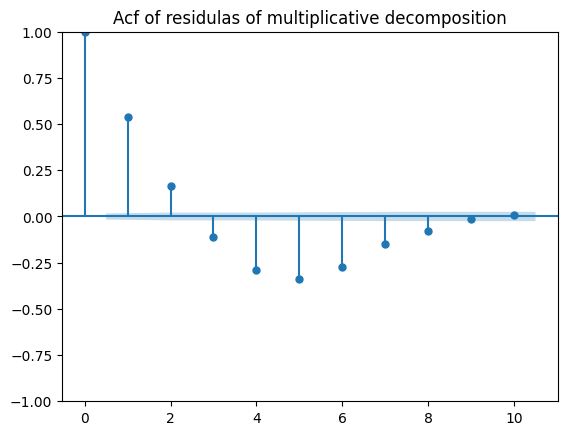

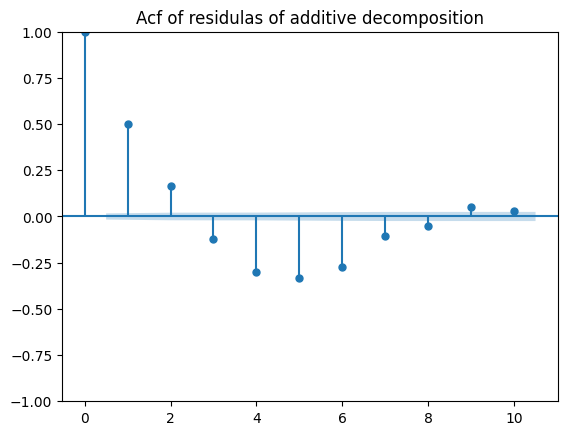

In [81]:
fig = tsaplots.plot_acf(result_mult.resid, lags=10)
plt.title('Acf of residulas of multiplicative decomposition')
plt.show()

fig = tsaplots.plot_acf(result_add.resid, lags=10)
plt.title('Acf of residulas of additive decomposition')
plt.show()

## Lag plots

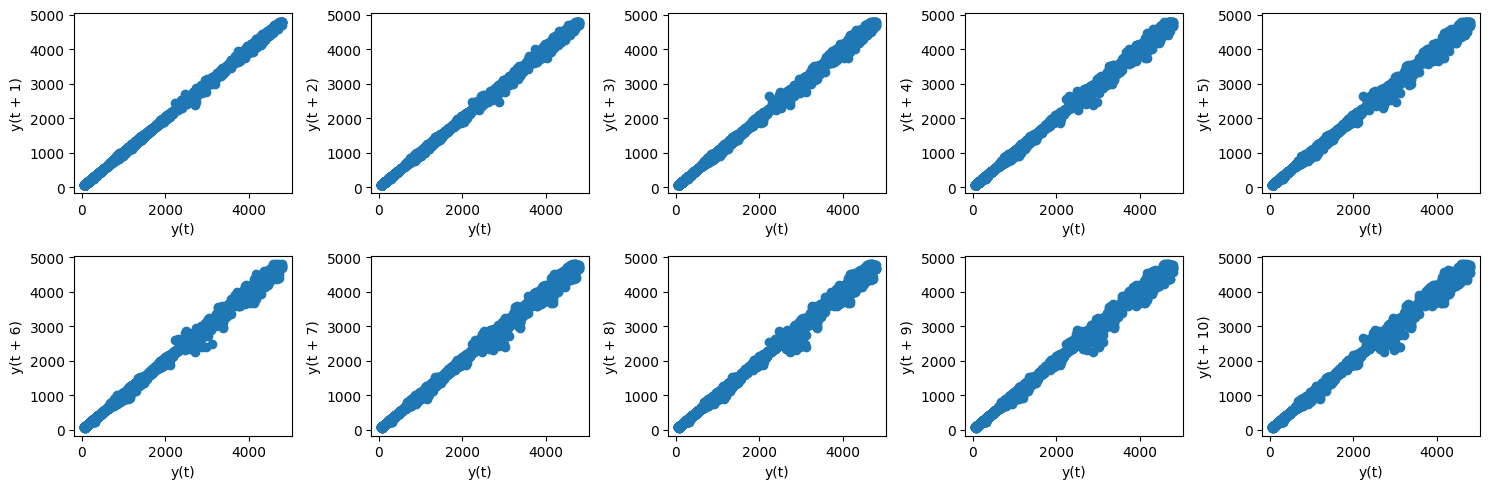

In [82]:
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    pd.plotting.lag_plot(df[var],lag=i)

plt.tight_layout()
plt.show()


## ACF Plot

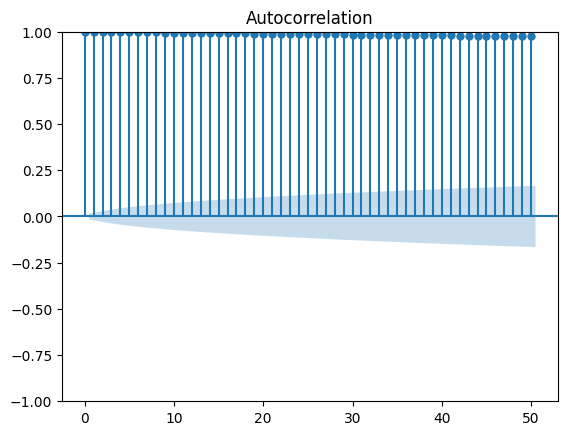

[1.         0.99943975 0.99890089 0.99835313 0.99781477 0.99728266
 0.99676127 0.99625775 0.9957313  0.99521456 0.99466877]


In [83]:
acf= sm.tsa.acf(df[var],nlags=10)
fig = tsaplots.plot_acf(df[var], lags=50)
plt.show()
print(acf)

# Analysing the daily difference

In [84]:
daily_diff = df.diff()
daily_diff = daily_diff.dropna()
daily_diff.describe()


open          high           low         close      adjclose  \
count  13570.000000  13570.000000  13570.000000  13570.000000  13570.000000   
mean       0.353071      0.347187      0.344943      0.345894      0.345894   
std       15.679420     13.587431     15.350416     17.218760     17.218760   
min     -194.739990   -164.650146   -228.359863   -324.890137   -324.890137   
25%       -1.699982     -1.537491     -1.680006     -1.867523     -1.867523   
50%        0.000000      0.110001      0.190002      0.139999      0.139999   
75%        2.969994      2.500000      2.869995      2.937469      2.937469   
max      170.039795    148.979980    172.180176    230.380127    230.380127   

             volume  
count  1.357000e+04  
mean   8.893810e+04  
std    4.464913e+08  
min   -5.044220e+09  
25%   -3.936000e+07  
50%    0.000000e+00  
75%    3.790000e+07  
max    4.637230e+09

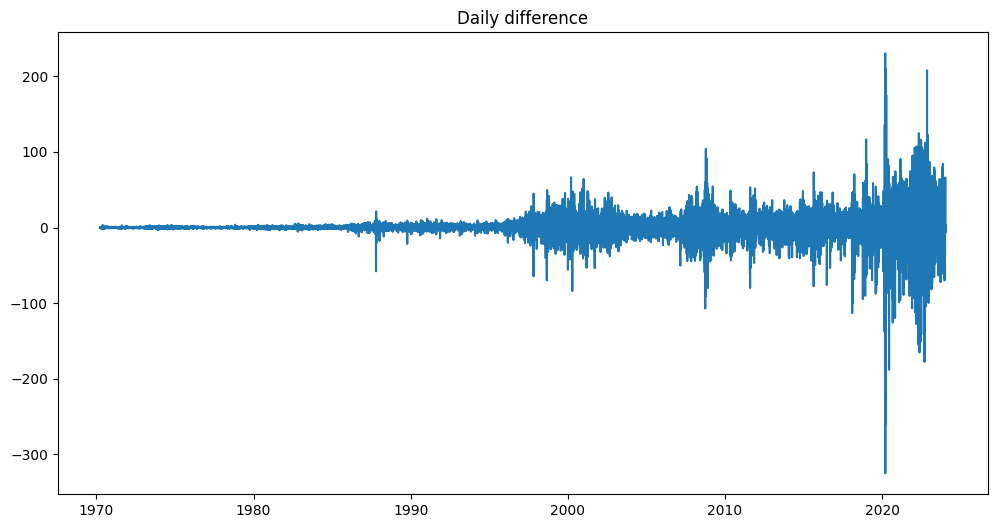

In [85]:
plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(daily_diff.index,daily_diff[var])
plt.title('Daily difference')
plt.show()

## Check for stationary

In [86]:
result = adfuller(daily_diff[var])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The time series is stationary.\n\n")
else:
    print("The time series is non-stationary.\n\n")

result = kpss(daily_diff[var])
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print("The time series is non-stationary.")
else:
    print("The time series is stationary.")

ADF Statistic: -20.018861585462037
p-value: 0.0
Critical Values: {'1%': -3.430833481761374, '5%': -2.861753676315736, '10%': -2.5668837350416474}
The time series is stationary.


KPSS Statistic: 0.7653487546627709
p-value: 0.01
The time series is non-stationary.


C:\Users\GODA\AppData\Local\Temp\ipykernel_14672\3128835151.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(daily_diff[var])


## ACF of daily differences

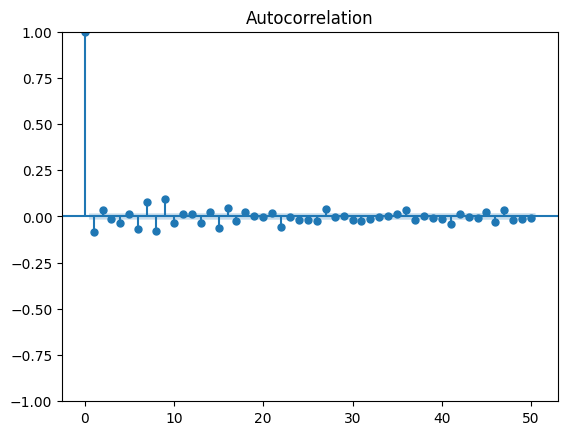

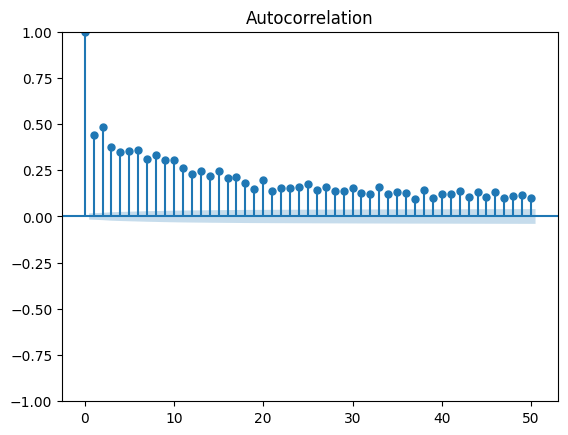

In [87]:
tsaplots.plot_acf(daily_diff[var], lags=50)
plt.show()

returns_sqr = map(lambda x: x*x , daily_diff[var])

tsaplots.plot_acf(list(returns_sqr), lags=50)
plt.show()

# tsaplots.plot_pacf(daily_diff[var],lags=50)
# plt.show()

## Lag plots of daily differences

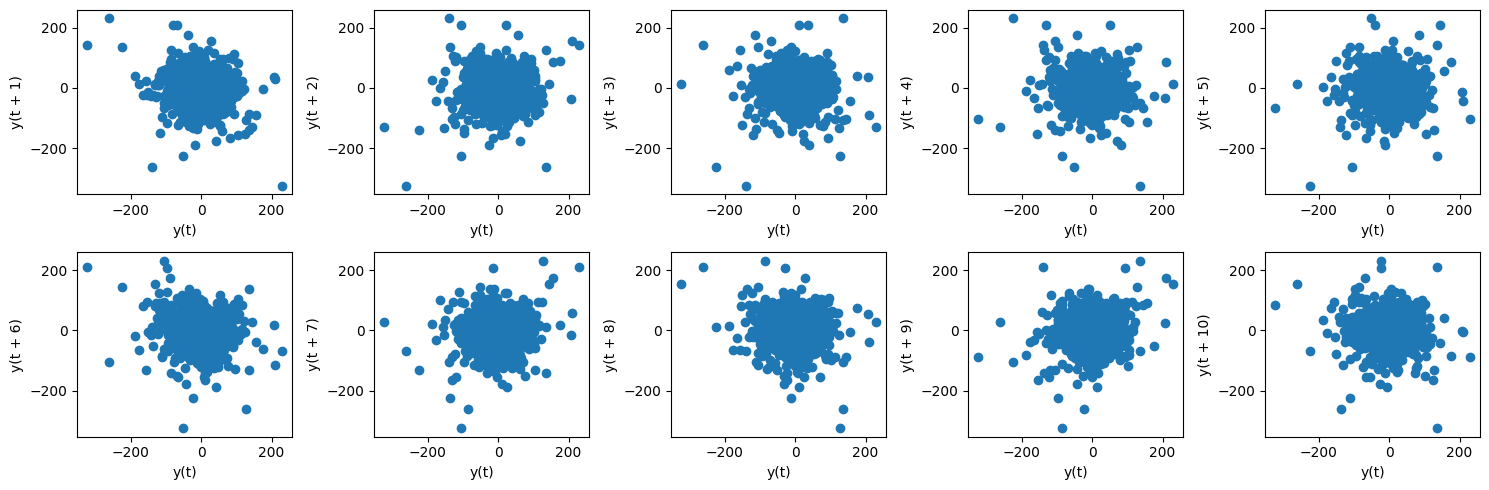

In [88]:
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    pd.plotting.lag_plot(daily_diff[var],lag=i)

plt.tight_layout()
plt.show()

## Decomposition of daily differences

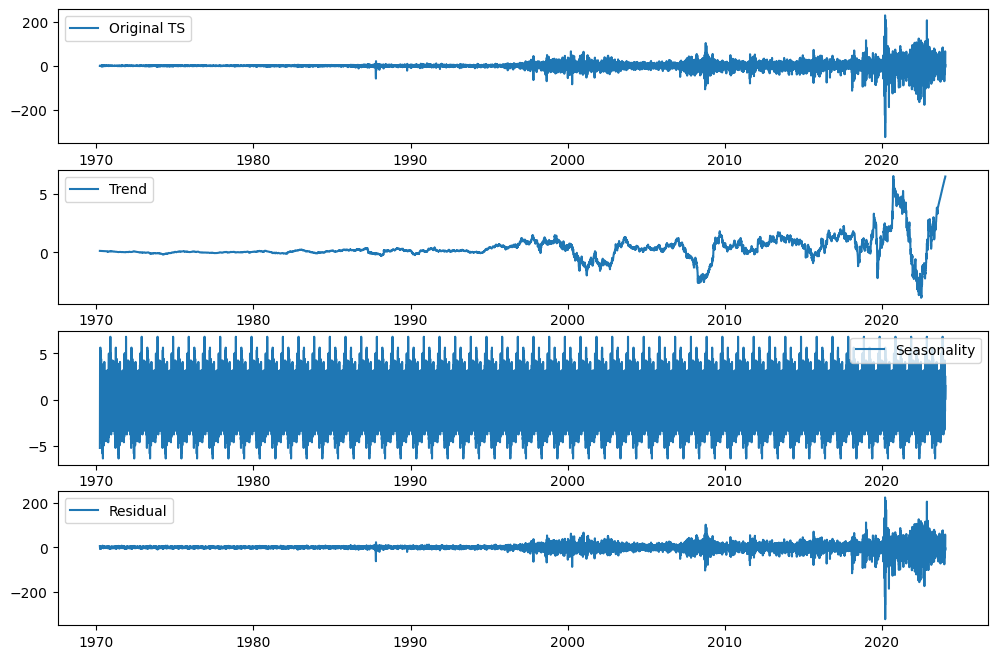

In [89]:
result_add = seasonal_decompose(daily_diff[var], model='additive',period=252, extrapolate_trend='freq' )

plot_decompostion(daily_diff,var,result_add)

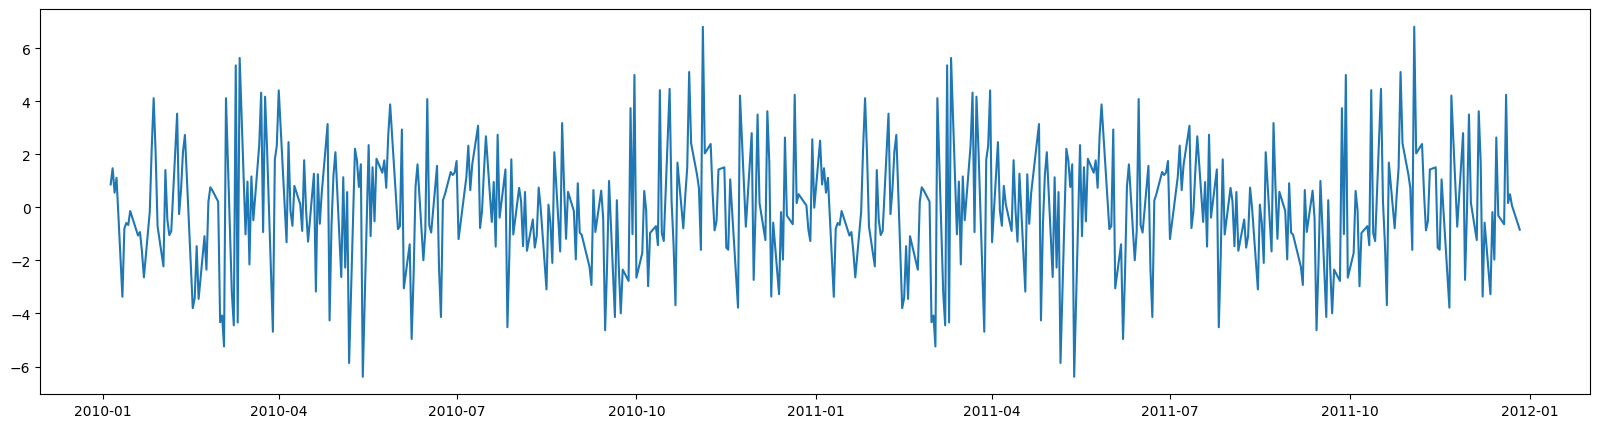

In [90]:
plt.figure(figsize=(20,5))
plt.plot(result_add.seasonal[10040:10540], label='Residual')
plt.show()

# Analysing the data monthly

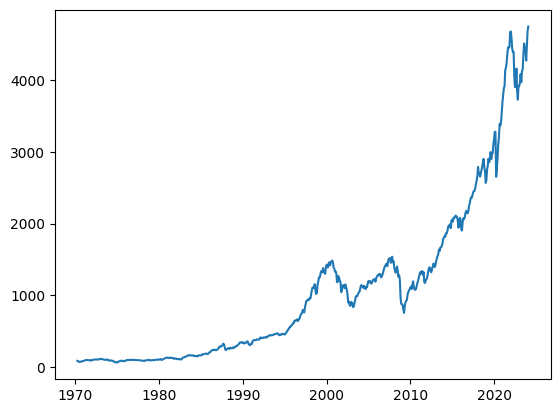

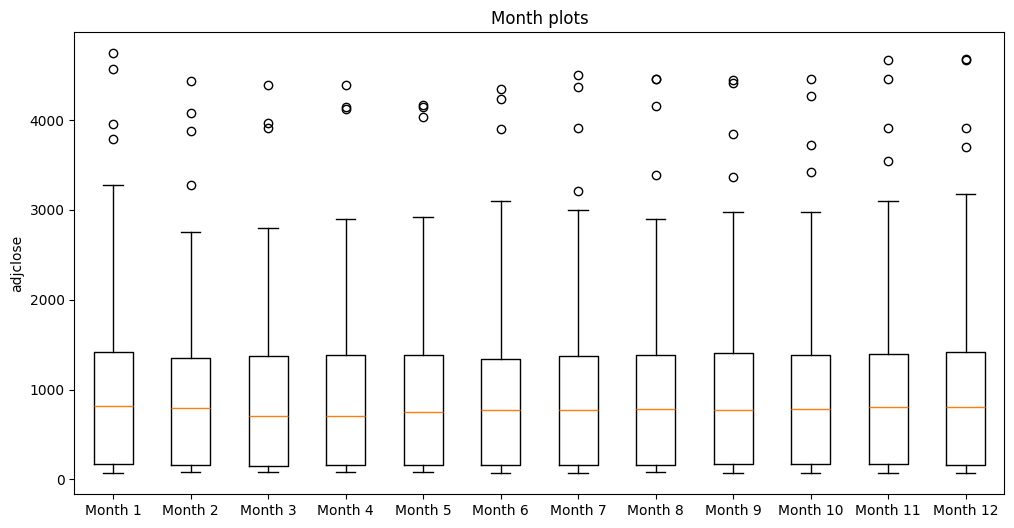

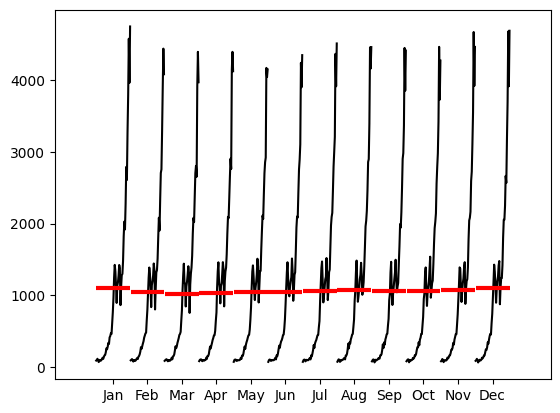

In [91]:
monthly_data = df.resample('M').mean()

plt.plot(monthly_data.index,monthly_data[var])
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

data_boxplots = [group[var].values for month, group in monthly_data.groupby(monthly_data.index.month)]

ax.boxplot(data_boxplots, labels=[f'Month {month}' for month in range(1, 13)])
ax.set_ylabel(var)
ax.set_title('Month plots')

plt.show()

fig = sm.graphics.tsa.month_plot(monthly_data[var])
plt.show()


## The evolution of the monthly difference

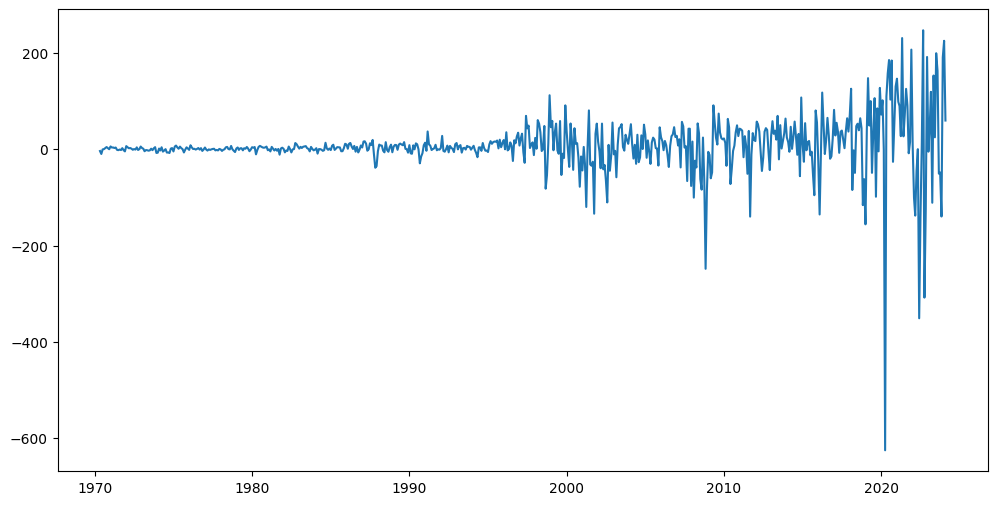

In [92]:
monthly_diff = monthly_data.diff()

plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(monthly_diff.index,monthly_diff[var])
plt.show()

# Analysing the box-cox transformation

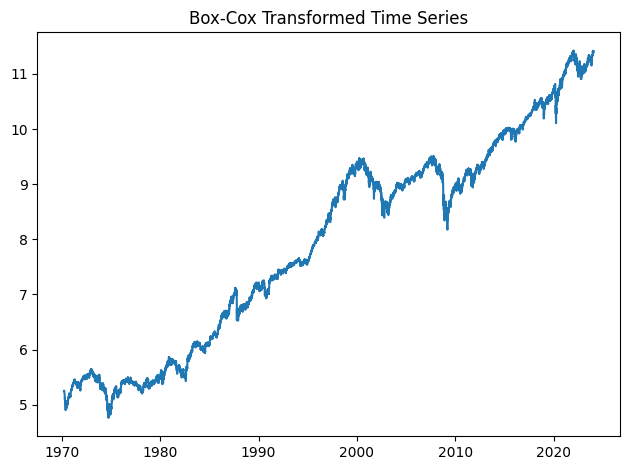

Optimal lambda value: 0.06717867638323968


In [93]:
transformed_values, lambda_value = boxcox(df[var])

plt.plot(df.index, transformed_values)
plt.title('Box-Cox Transformed Time Series')

plt.tight_layout()
plt.show()

print(f'Optimal lambda value: {lambda_value}')

## Decomposition of box-cox transformation

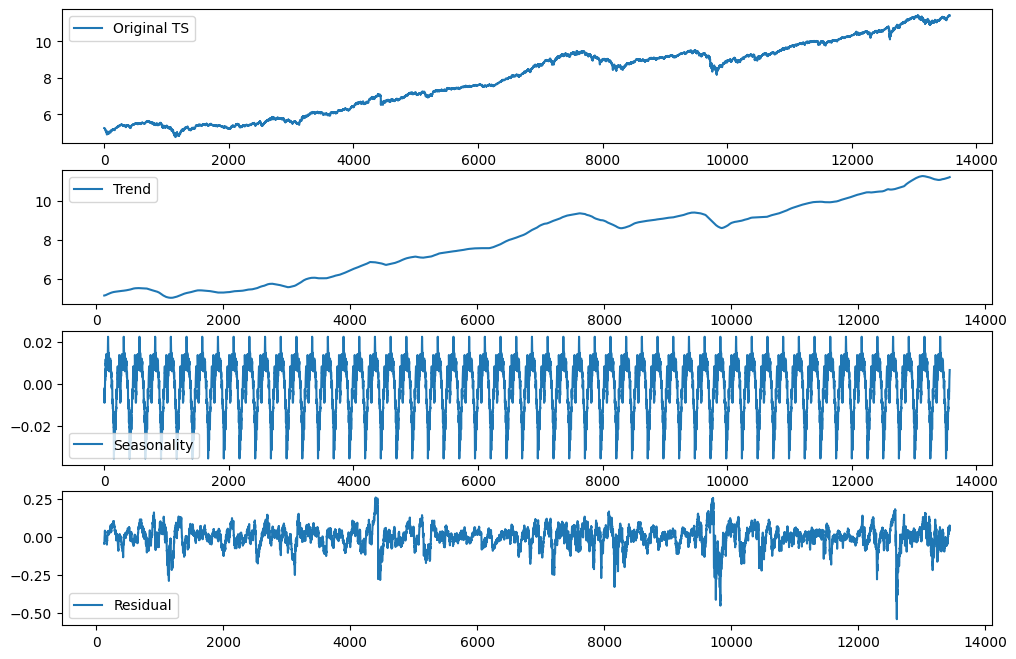

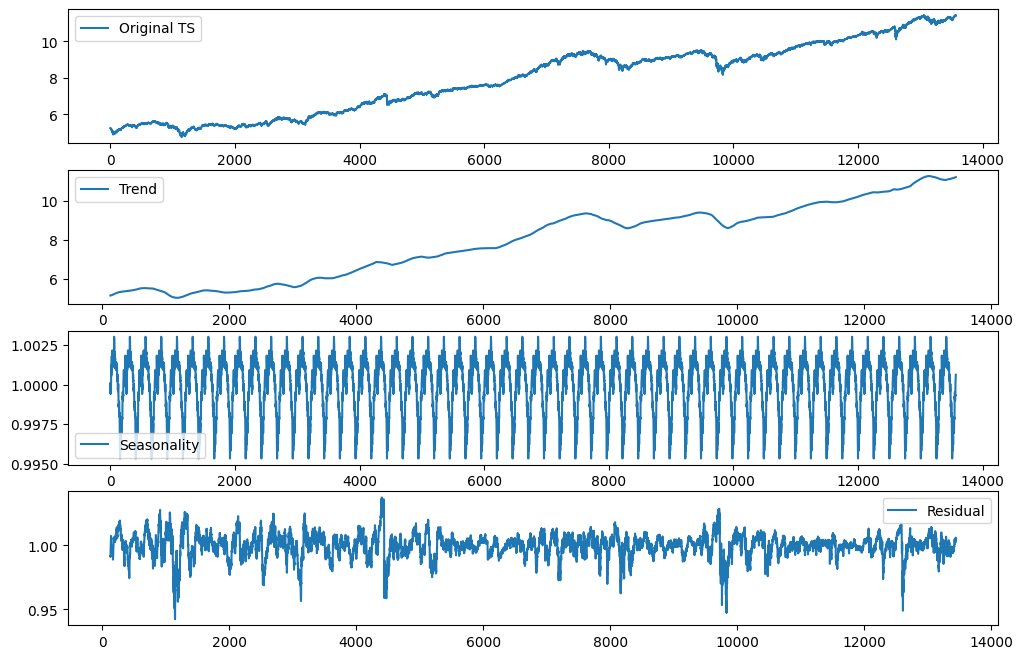

In [94]:
decompose_add=seasonal_decompose(transformed_values, model='additive', period=252)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

plt.show()

decompose_mult=seasonal_decompose(transformed_values, model='multiplicative', period=252)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_mult.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_mult.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_mult.resid, label='Residual')
plt.legend(loc='best')

plt.show()

## Lag plots of box-cox transformation

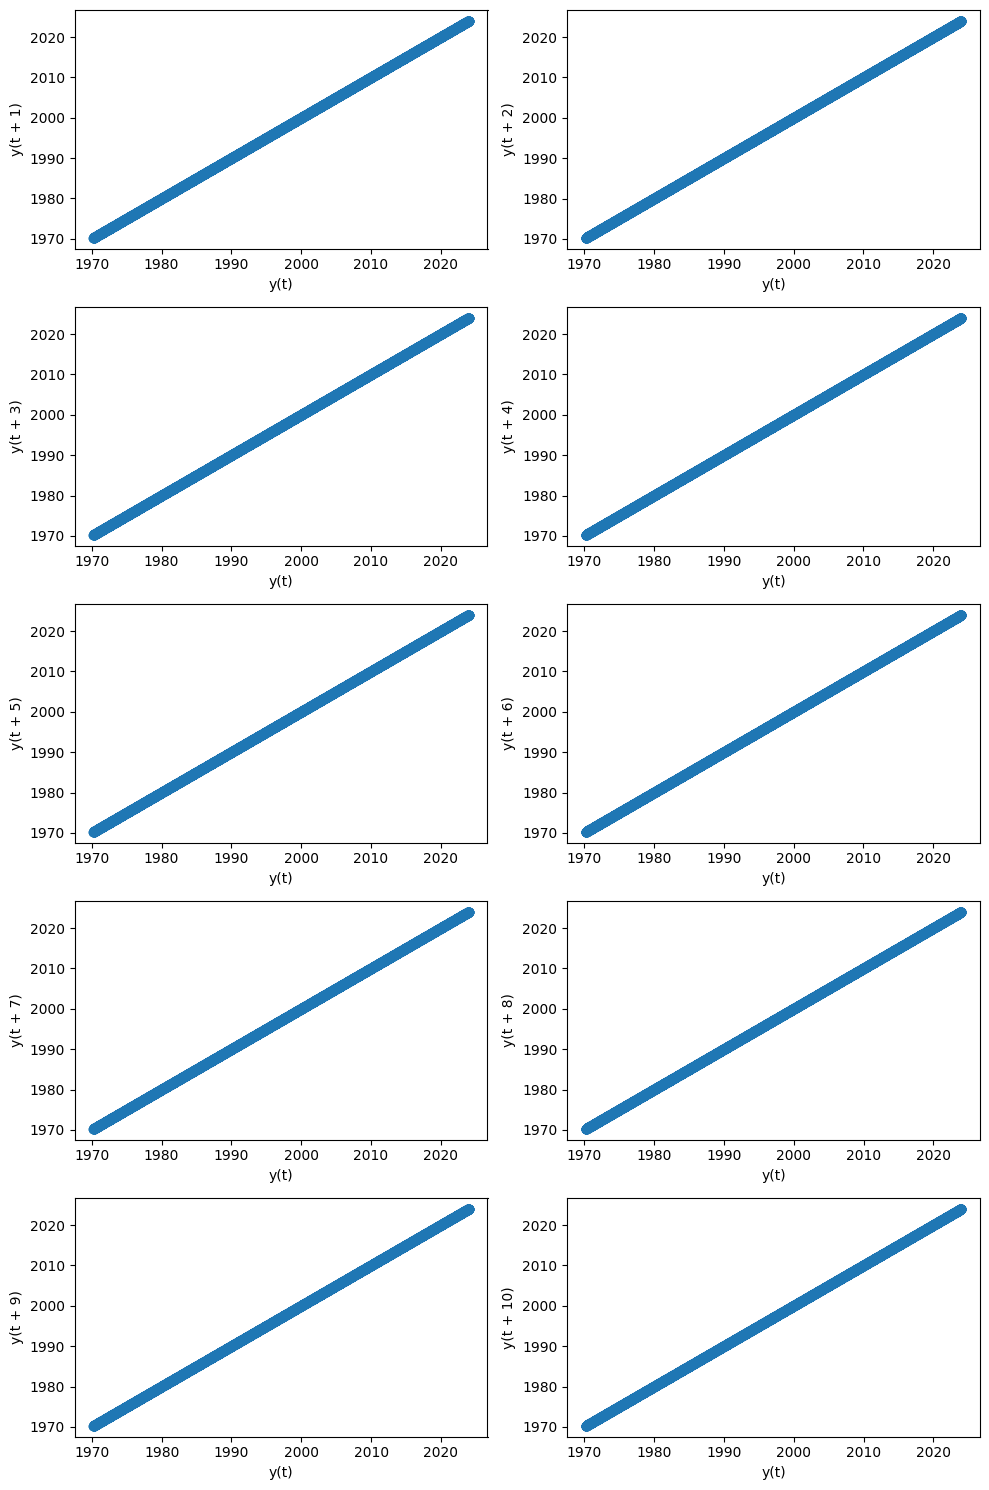

In [95]:
transformed_df = pd.Series(df.index,transformed_values)

plt.figure(figsize=(10,15))
for i in range(1,11):
    plt.subplot(5,2,i)
    pd.plotting.lag_plot(transformed_df,lag=i)

plt.tight_layout()
plt.show()

## ACF of box-cox transformation

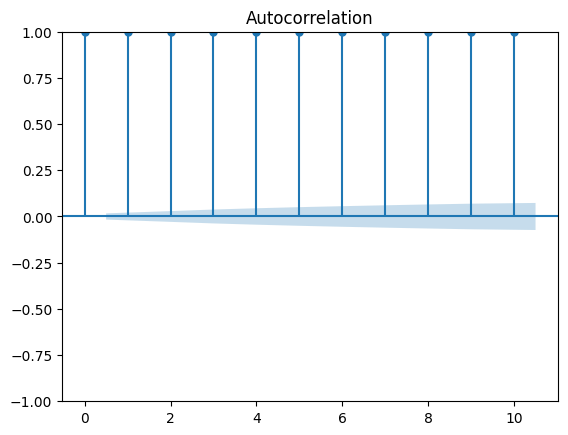

In [96]:
acf= sm.tsa.acf(transformed_values)
fig = tsaplots.plot_acf(transformed_values, lags=10)
plt.show()

In [97]:
daily_diff.describe()

open          high           low         close      adjclose  \
count  13570.000000  13570.000000  13570.000000  13570.000000  13570.000000   
mean       0.353071      0.347187      0.344943      0.345894      0.345894   
std       15.679420     13.587431     15.350416     17.218760     17.218760   
min     -194.739990   -164.650146   -228.359863   -324.890137   -324.890137   
25%       -1.699982     -1.537491     -1.680006     -1.867523     -1.867523   
50%        0.000000      0.110001      0.190002      0.139999      0.139999   
75%        2.969994      2.500000      2.869995      2.937469      2.937469   
max      170.039795    148.979980    172.180176    230.380127    230.380127   

             volume  
count  1.357000e+04  
mean   8.893810e+04  
std    4.464913e+08  
min   -5.044220e+09  
25%   -3.936000e+07  
50%    0.000000e+00  
75%    3.790000e+07  
max    4.637230e+09

# Model

In [98]:
returns = df['adjclose'].pct_change()
returns = returns[1:] *100
print(returns)
returns_sqr = list(map(lambda x:x*x,returns))

1970-03-26    0.167095
1970-03-30   -0.322510
1970-03-31    0.000000
1970-04-01    0.490910
1970-04-02   -0.310868
                ...   
2024-01-08    1.411463
2024-01-09   -0.147790
2024-01-10    0.566597
2024-01-11   -0.067106
2024-01-12    0.069234
Name: adjclose, Length: 13570, dtype: float64


Returns


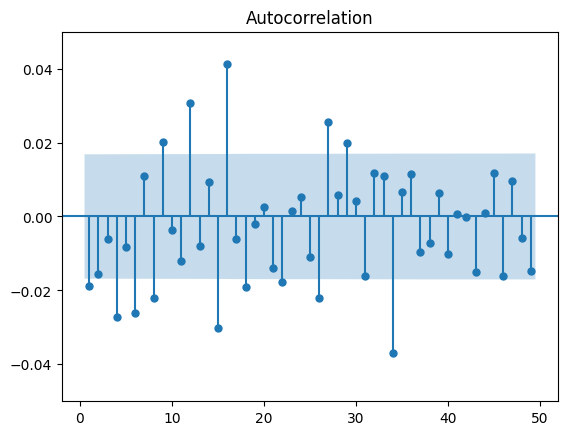

[ 1.         -0.0188131  -0.01568287 -0.0061113  -0.02707091 -0.00830245
 -0.02621491  0.01094972 -0.02209266  0.02015652 -0.00361011]


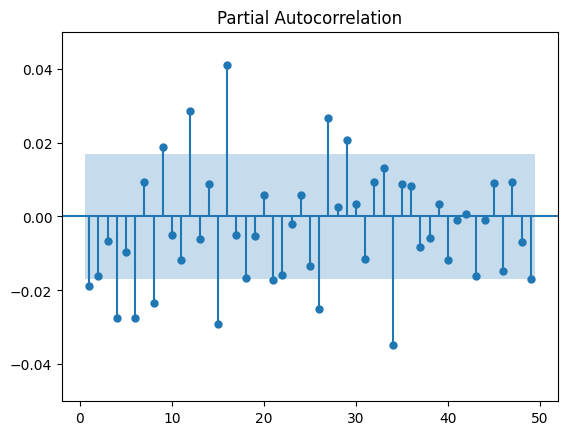

[ 1.         -0.01881449 -0.01604484 -0.00671848 -0.0275946  -0.00957915
 -0.02754464  0.00925274 -0.02354054  0.01880391 -0.00510284]


In [99]:
print("Returns")
acf= sm.tsa.acf(returns,nlags=10)
fig = tsaplots.plot_acf(returns, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)

pacf= sm.tsa.pacf(returns,nlags=10)
fig = tsaplots.plot_pacf(returns, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

Returns square


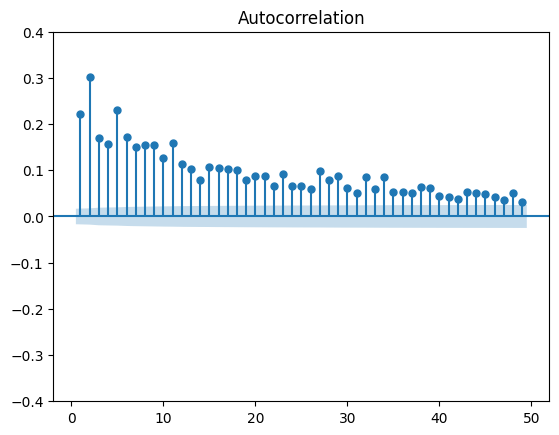

[1.         0.22139111 0.30176573 0.16881408 0.15719317 0.23098239
 0.17192651 0.15129227 0.15471352 0.15538431 0.12712381]


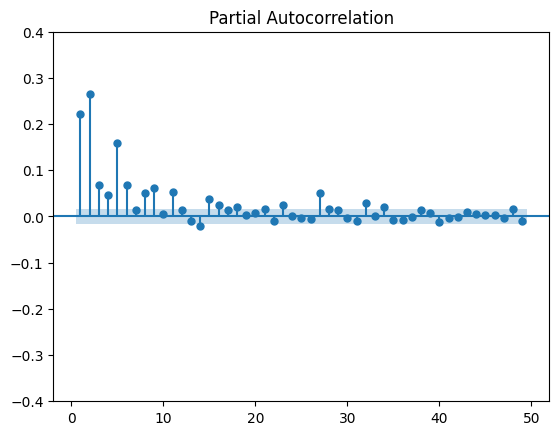

[1.         0.22140743 0.26581977 0.06894999 0.04635903 0.15818526
 0.06797671 0.01390027 0.05030683 0.06209732 0.00599172]


In [100]:
print("Returns square")
acf= sm.tsa.acf(returns_sqr,nlags=10)
fig = tsaplots.plot_acf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(acf)

pacf= sm.tsa.pacf(returns_sqr,nlags=10)
fig = tsaplots.plot_pacf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(pacf)

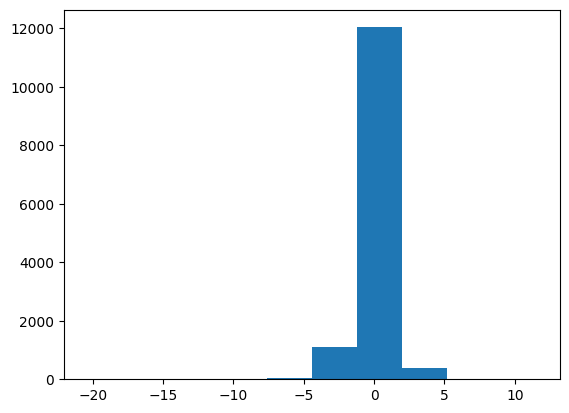

In [101]:
plt.hist(returns)
plt.show()

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


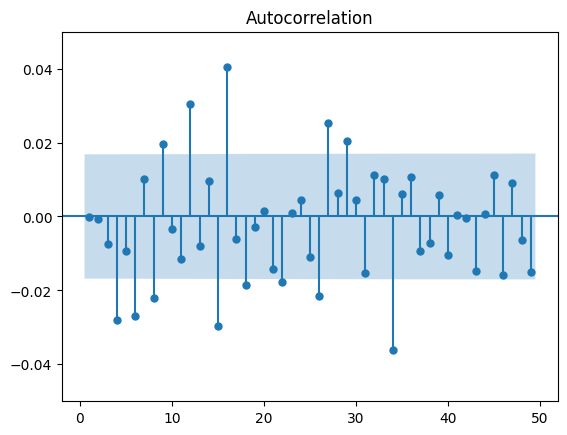

[ 1.00000000e+00 -1.08644917e-04 -5.58523623e-04 -7.39608465e-03
 -2.80651105e-02 -9.28321388e-03 -2.69863536e-02  1.02157179e-02
 -2.19937279e-02  1.96550391e-02 -3.33535089e-03]


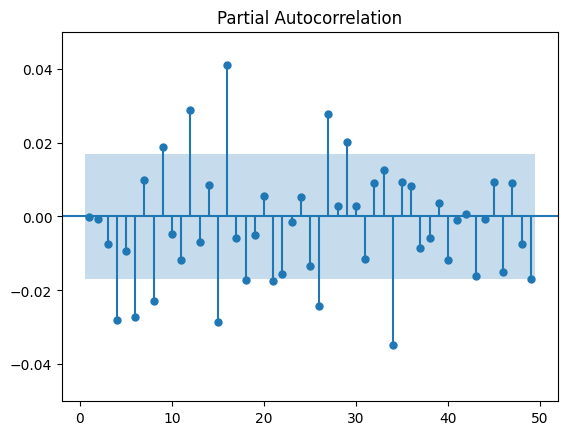

[ 1.00000000e+00 -1.08652925e-04 -5.58617777e-04 -7.39784417e-03
 -2.80768837e-02 -9.31493019e-03 -2.71184881e-02  9.77209556e-03
 -2.30146769e-02  1.87892029e-02 -4.87573258e-03]


In [102]:
model_ar = AutoReg(returns,lags=2)
results = model_ar.fit()

acf= sm.tsa.acf(results.resid,nlags=10)
fig = tsaplots.plot_acf(results.resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)

pacf= sm.tsa.pacf(results.resid,nlags=10)
fig = tsaplots.plot_pacf(results.resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 304022324052256.25
Iteration:      2,   Func. Count:     13,   Neg. LLF: 7521764338.419909
Iteration:      3,   Func. Count:     19,   Neg. LLF: 20434.764331837676
Iteration:      4,   Func. Count:     25,   Neg. LLF: 19476.892976011874
Iteration:      5,   Func. Count:     30,   Neg. LLF: 19437.26029699452
Iteration:      6,   Func. Count:     34,   Neg. LLF: 19437.260272428186
Iteration:      7,   Func. Count:     37,   Neg. LLF: 19437.260272428175
Optimization terminated successfully    (Exit mode 0)
            Current function value: 19437.260272428186
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 7


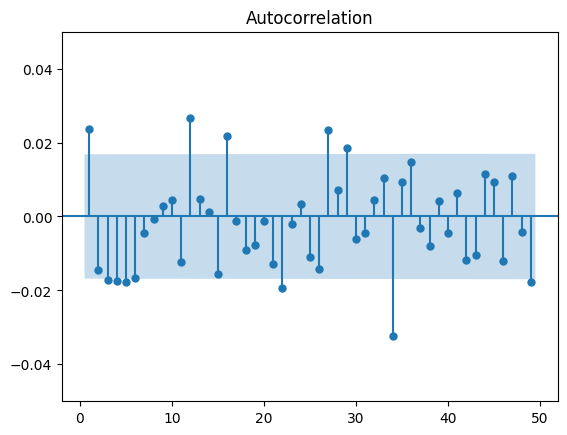

[ 1.00000000e+00  2.35805941e-02 -1.45045836e-02 -1.70565052e-02
 -1.75143331e-02 -1.77030451e-02 -1.67698883e-02 -4.58764506e-03
 -5.88737211e-04  2.90805868e-03  4.46711974e-03]


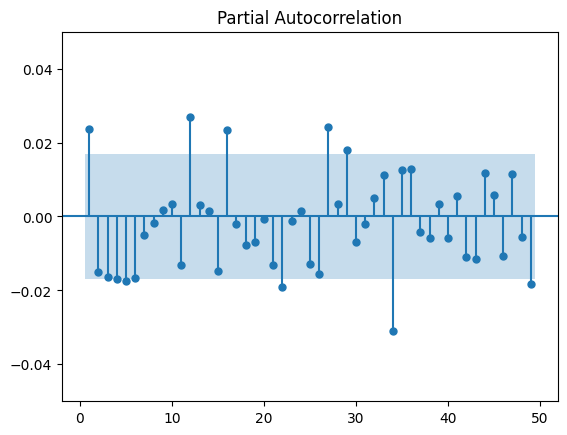

[ 1.          0.02358233 -0.01507123 -0.01637042 -0.01696004 -0.01740905
 -0.01676826 -0.00491803 -0.00175619  0.00166267  0.00329939]


In [103]:
model_arch = arch_model(returns,vol="ARCH",p=1)
result = model_arch.fit()

acf= sm.tsa.acf(result.std_resid,nlags=10)
tsaplots.plot_acf(result.std_resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(result.std_resid,nlags=10)
tsaplots.plot_pacf(result.std_resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2793128481940880.0
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7565303722.194361
Iteration:      3,   Func. Count:     24,   Neg. LLF: 17895.528211589157
Iteration:      4,   Func. Count:     30,   Neg. LLF: 17800.324631275176
Iteration:      5,   Func. Count:     36,   Neg. LLF: 17940.35762190012
Iteration:      6,   Func. Count:     42,   Neg. LLF: 21592.920587186538
Iteration:      7,   Func. Count:     49,   Neg. LLF: 17754.74607768052
Iteration:      8,   Func. Count:     55,   Neg. LLF: 17753.76199791706
Iteration:      9,   Func. Count:     60,   Neg. LLF: 17753.75969122914
Iteration:     10,   Func. Count:     65,   Neg. LLF: 17753.759682546173
Iteration:     11,   Func. Count:     69,   Neg. LLF: 17753.759682542695
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17753.759682546173
            Iterations: 11
            Function evaluations: 69
            Gradient evaluati

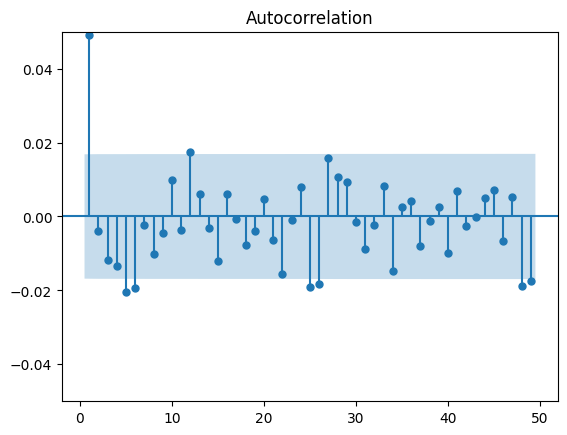

[ 1.          0.04917075 -0.00396332 -0.01172457 -0.01326411 -0.02049836
 -0.01943633 -0.00229184 -0.01007825 -0.004471    0.00973562]


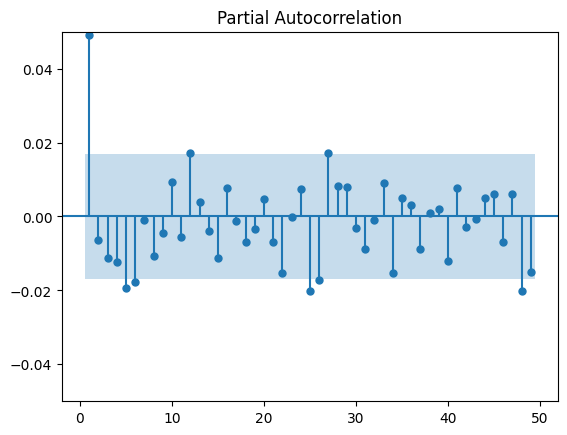

[ 1.00000000e+00  4.91743701e-02 -6.39748963e-03 -1.12440535e-02
 -1.21902414e-02 -1.94172078e-02 -1.77915991e-02 -9.55831192e-04
 -1.07488312e-02 -4.39570639e-03  9.22499858e-03]


In [104]:
model_garch = arch_model(returns,vol="GARCH",p=1,q=1)
result = model_garch.fit()

acf= sm.tsa.acf(result.std_resid,nlags=10)
tsaplots.plot_acf(result.std_resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(result.std_resid,nlags=10)
tsaplots.plot_pacf(result.std_resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

# Model v2

Returns square


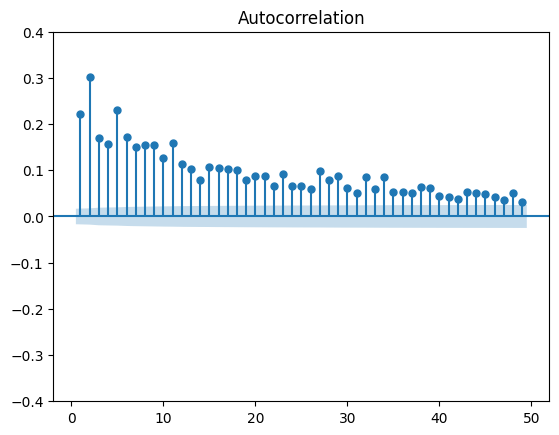

[1.         0.22139111 0.30176573 0.16881408 0.15719317 0.23098239
 0.17192651 0.15129227 0.15471352 0.15538431 0.12712381]


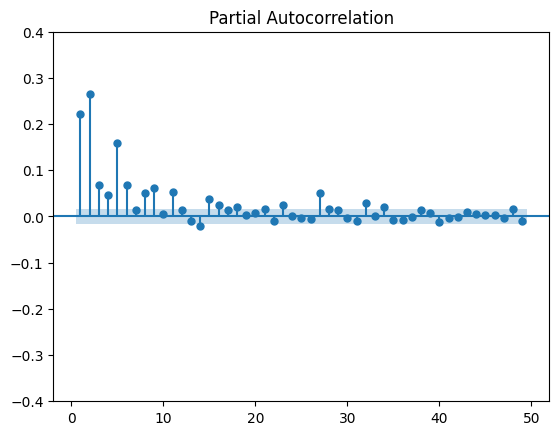

[1.         0.22140743 0.26581977 0.06894999 0.04635903 0.15818526
 0.06797671 0.01390027 0.05030683 0.06209732 0.00599172]


In [105]:
print("Returns square")
acf= sm.tsa.acf(returns_sqr,nlags=10)
fig = tsaplots.plot_acf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(acf)

pacf= sm.tsa.pacf(returns_sqr,nlags=10)
fig = tsaplots.plot_pacf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(pacf)

In [106]:
model1 = arch_model(returns,vol="GARCH",p=1,q=1)
results1 = model1.fit()

model2 = arch_model(returns,vol="GARCH",p=2,q=1)
results2 = model2.fit()

model3 = arch_model(returns,vol="GARCH",p=3,q=1)
results3 = model3.fit()

model4 = arch_model(returns,vol="GARCH",p=4,q=1)
results4 = model4.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2793128481940880.0


Iteration:      2,   Func. Count:     16,   Neg. LLF: 7565303722.194361
Iteration:      3,   Func. Count:     24,   Neg. LLF: 17895.528211589157
Iteration:      4,   Func. Count:     30,   Neg. LLF: 17800.324631275176
Iteration:      5,   Func. Count:     36,   Neg. LLF: 17940.35762190012
Iteration:      6,   Func. Count:     42,   Neg. LLF: 21592.920587186538
Iteration:      7,   Func. Count:     49,   Neg. LLF: 17754.74607768052
Iteration:      8,   Func. Count:     55,   Neg. LLF: 17753.76199791706
Iteration:      9,   Func. Count:     60,   Neg. LLF: 17753.75969122914
Iteration:     10,   Func. Count:     65,   Neg. LLF: 17753.759682546173
Iteration:     11,   Func. Count:     69,   Neg. LLF: 17753.759682542695
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17753.759682546173
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      7,   Neg. LLF: 8331189826

In [107]:
print(results1.aic)
print(results2.aic)
print(results3.aic)
print(results4.aic)
print(results1.bic)
print(results2.bic)
print(results3.bic)
print(results4.bic)
print(results1.loglikelihood)
print(results2.loglikelihood)
print(results3.loglikelihood)
print(results4.loglikelihood)

35515.51936509235
35517.51936506424
35519.519366724846
35521.51936506421
35545.581832103664
35555.09744882838
35564.61306724182
35574.12868233401
-17753.759682546173
-17753.75968253212
-17753.759683362423
-17753.759682532105


In [108]:
model1 = arch_model(returns,vol="GARCH",p=1,q=1)
results1 = model1.fit()

model2 = arch_model(returns,vol="GARCH",p=1,q=2)
results2 = model2.fit()

model3 = arch_model(returns,vol="GARCH",p=1,q=3)
results3 = model3.fit()

model4 = arch_model(returns,vol="GARCH",p=1,q=4)
results4 = model4.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2793128481940880.0
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7565303722.194361
Iteration:      3,   Func. Count:     24,   Neg. LLF: 17895.528211589157
Iteration:      4,   Func. Count:     30,   Neg. LLF: 17800.324631275176
Iteration:      5,   Func. Count:     36,   Neg. LLF: 17940.35762190012
Iteration:      6,   Func. Count:     42,   Neg. LLF: 21592.920587186538
Iteration:      7,   Func. Count:     49,   Neg. LLF: 17754.74607768052
Iteration:      8,   Func. Count:     55,   Neg. LLF: 17753.76199791706
Iteration:      9,   Func. Count:     60,   Neg. LLF: 17753.75969122914
Iteration:     10,   Func. Count:     65,   Neg. LLF: 17753.759682546173
Iteration:     11,   Func. Count:     69,   Neg. LLF: 17753.759682542695
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17753.759682546173
            Iterations: 11
            Function evaluations: 69
            Gradient evaluati

In [109]:
print(results1.aic)
print(results2.aic)
print(results3.aic)
print(results4.aic)
print(results1.bic)
print(results2.bic)
print(results3.bic)
print(results4.bic)
print(results1.loglikelihood)
print(results2.loglikelihood)
print(results3.loglikelihood)
print(results4.loglikelihood)

35515.51936509235
35517.286892416596
35517.12488185118
35519.05457529671
35545.581832103664
35554.86497618074
35562.21858236816
35571.66389256651
-17753.759682546173
-17753.643446208298
-17752.56244092559
-17752.527287648354


# Final model

In [110]:
train_size = 0.8
train_data, test_data = train_test_split(returns, train_size=train_size, shuffle=False)

In [111]:
model_final = arch_model(train_data,vol="GARCH",p=1,q=1)

results_final = model_final.fit(disp='off')
print(results_final.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               adjclose   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14317.2
Distribution:                  Normal   AIC:                           28642.4
Method:            Maximum Likelihood   BIC:                           28671.6
                                        No. Observations:                10856
Date:                Fri, Jan 12 2024   Df Residuals:                    10855
Time:                        18:53:29   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0506  8.043e-03      6.292  3.140e-10 [3.

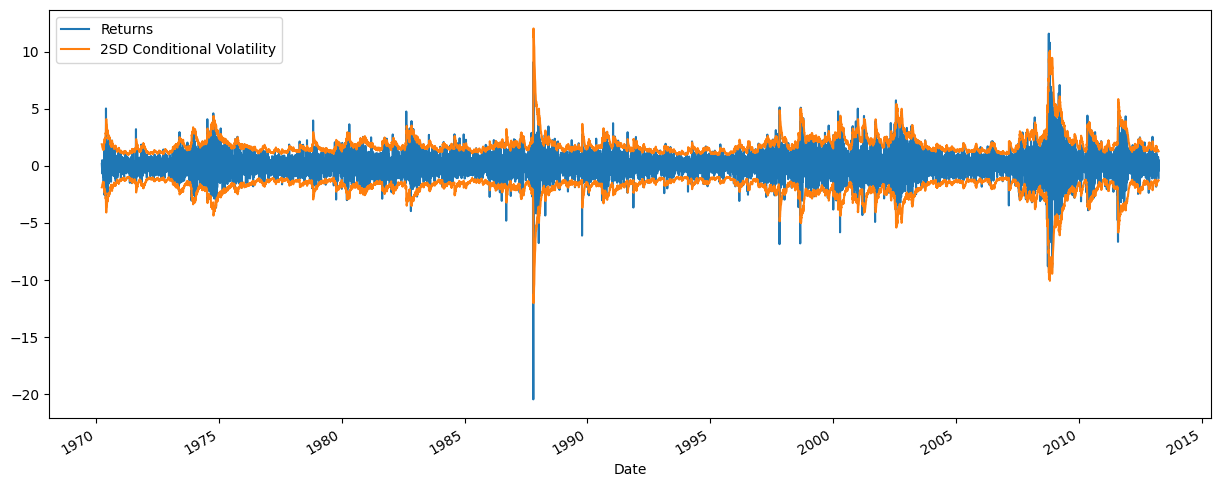

In [112]:
plt.subplots(figsize=(15, 6))

train_data.plot(label='Returns')

(2 * results_final.conditional_volatility).plot(color='C1',label='2SD Conditional Volatility')

(-2 * results_final.conditional_volatility).rename('').plot(color='C1')

plt.xlabel('Date')

plt.legend()
plt.show()

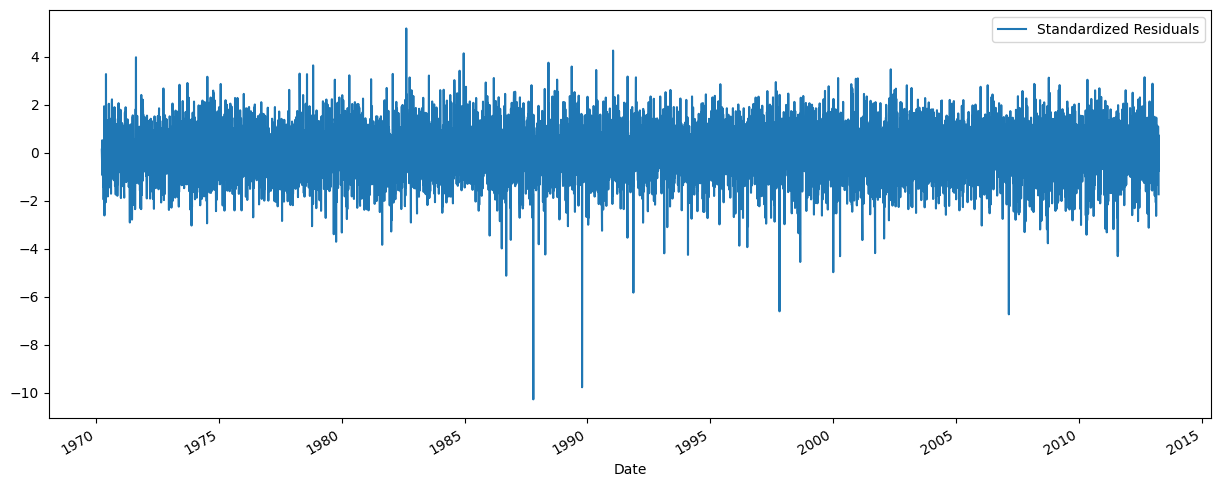

In [113]:
plt.subplots(figsize=(15, 6))

results_final.std_resid.plot(label='Standardized Residuals')

plt.xlabel('Date')
plt.legend()
plt.show()

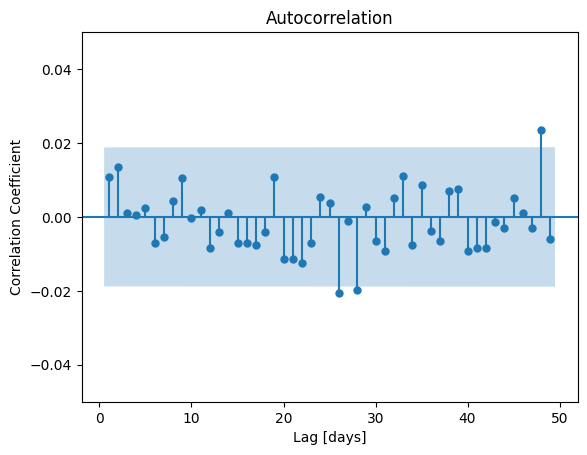

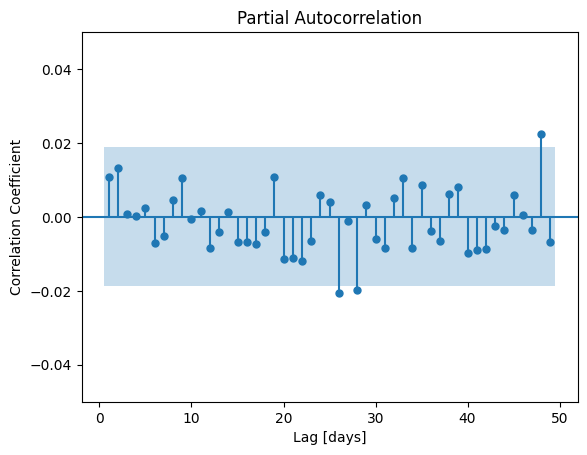

In [114]:
tsaplots.plot_acf(results_final.std_resid**2, lags=range(1,50))

plt.ylim([-0.05,0.05])
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()

tsaplots.plot_pacf(results_final.std_resid**2, lags=range(1,50))

plt.ylim([-0.05,0.05])
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()

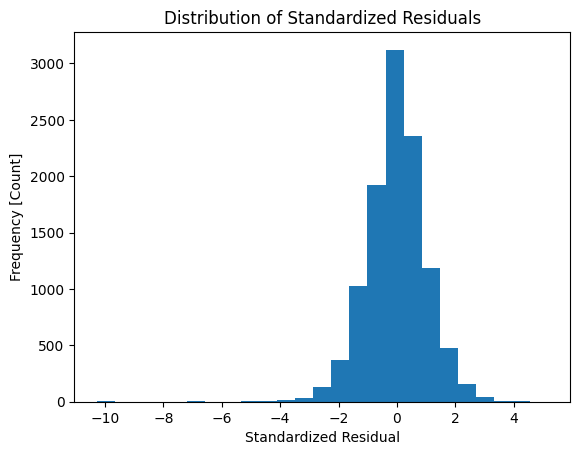

In [115]:
plt.hist(results_final.std_resid, bins=25)

plt.xlabel('Standardized Residual')
plt.ylabel('Frequency [Count]')

plt.title('Distribution of Standardized Residuals')
plt.show()

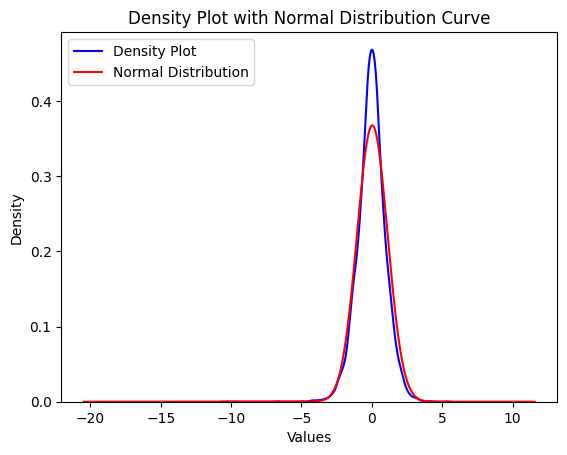

In [116]:
sns.kdeplot(results_final.std_resid, label='Density Plot', color='blue')
x = pd.Series(np.arange(min(returns), max(returns), 0.001))

# ??????
plt.plot(x, norm.pdf(x, loc=returns.mean(), scale=returns.std()), color='red', label='Normal Distribution')
plt.title('Density Plot with Normal Distribution Curve')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

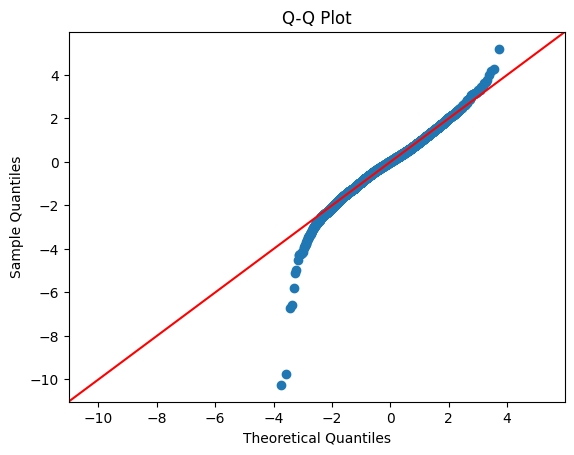

In [117]:
sm.qqplot(results_final.std_resid, line='45', fit=True)
plt.title('Q-Q Plot')
plt.show()

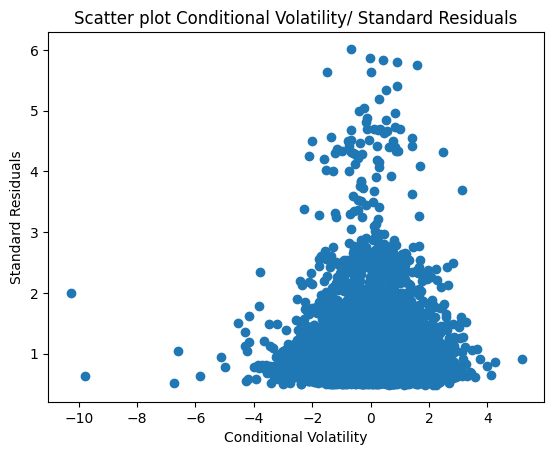

In [123]:
plt.scatter(x= results_final.std_resid, y= results_final.conditional_volatility)
plt.title('Scatter plot Conditional Volatility/ Standard Residuals')
plt.xlabel('Conditional Volatility')
plt.ylabel('Standard Residuals')
plt.show()

In [44]:
predictions = []

test_size = int(len(returns) *0.2)

for i in range(test_size):
    train_data = returns.iloc[:-(test_size-i)]

    model = arch_model(train_data,vol="GARCH",p=1,q=1)
    results_arch = model.fit(disp='off')

    next_pred = results_arch.forecast(horizon=1,reindex=False).variance.iloc[0,0] ** 0.5

    #train_data = pd.concat([train_data,pd.Series([next_pred])])
    
    predictions.append(next_pred)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 414825845486.15564
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5994289839.858743
Iteration:      3,   Func. Count:     25,   Neg. LLF: 62710438.31801239
Iteration:      4,   Func. Count:     31,   Neg. LLF: 14400.265205430751
Iteration:      5,   Func. Count:     37,   Neg. LLF: 14367.873623939282
Iteration:      6,   Func. Count:     43,   Neg. LLF: 14327.407367028187
Iteration:      7,   Func. Count:     49,   Neg. LLF: 14519.065444760106
Iteration:      8,   Func. Count:     55,   Neg. LLF: 14328.808654945666
Iteration:      9,   Func. Count:     62,   Neg. LLF: 14318.939652855639
Iteration:     10,   Func. Count:     68,   Neg. LLF: 14317.194247732881
Iteration:     11,   Func. Count:     73,   Neg. LLF: 14317.19294526451
Iteration:     12,   Func. Count:     78,   Neg. LLF: 14317.192944625745
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14317.192944625745
            Iterat

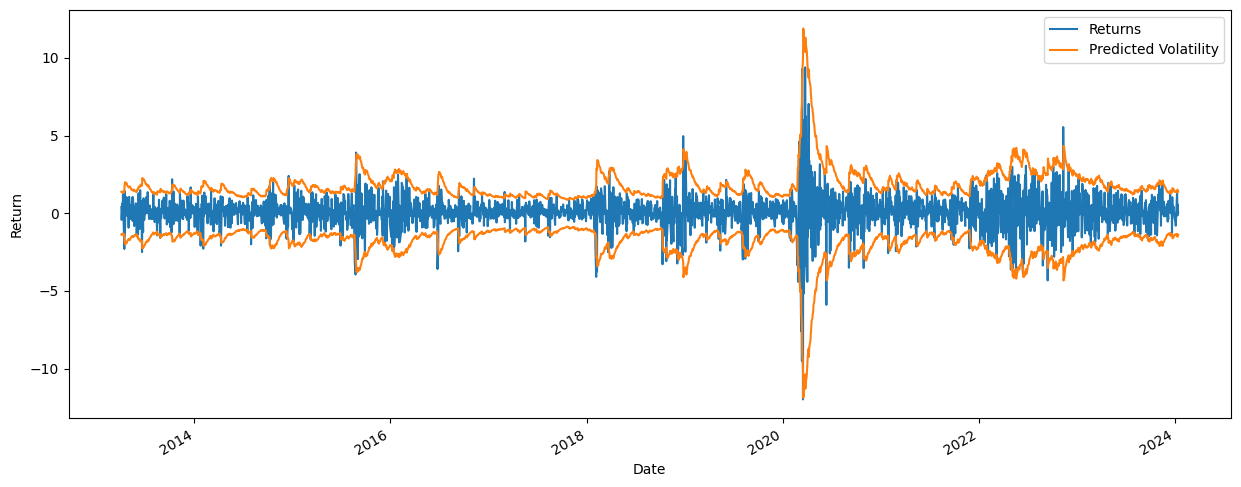

In [45]:
data_test_wfv = pd.Series(predictions, index=returns.tail(test_size).index)

plt.subplots(figsize=(15, 6))
returns.tail(test_size).plot( label="Returns")

(2 * data_test_wfv).plot(c="C1", label="Predicted Volatility")
(-2 * data_test_wfv).plot(c="C1")

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()